# Simple LSTM Neural Network for Stock Prediction

In [1]:
import numpy as np
import pandas as pd

In [2]:
import sys
sys.path.append('../')

import ron.datasources.datasources as datasources
from ron.pandas import extend_pandas
extend_pandas()

In [3]:
from importlib import reload
reload(datasources)

<module 'ron.datasources.datasources' from '../ron/datasources/datasources.py'>

## Data query

First we will use `pandas-datareader` module to query all the `Open`, `High`, `Low`, `Adj Close` and `Volume` an obvserved index of stocks.

In [4]:
TARGET_SYMBOL = "IBM"
OBSERVED_SYMBOLS = datasources.get_symbols_down_jones()
symbols = set([TARGET_SYMBOL] + OBSERVED_SYMBOLS)
print(symbols)

{'UTX', 'AAPL', 'PFE', 'WMT', 'DOW', 'CSCO', 'WBA', 'GS', 'HD', 'AXP', 'UNH', 'MCD', 'IBM', 'XOM', 'JPM', 'KO', 'BA', 'MMM', 'NKE', 'DIS', 'JNJ', 'CAT', 'PG', 'V', 'MRK', 'MSFT', 'CVX', 'TRV', 'INTC', 'VZ'}


In [5]:

# TICKER = yf.Ticker(SYMBOL)
data, report, log, errors = datasources.timeseries(symbols, period='10y')
print(errors)
print(log)
report



                                               0
First Index                  2011-01-03 00:00:00
Last Index                   2020-04-01 00:00:00
Series shape                         (2328, 150)
Inconsistent Symbol Dropped                  DOW


UTX                         IBM                         \
                     Open High  Low Close Volume Open High  Low Close Volume   
Consecutive NaN       1.0  1.0  1.0   1.0    1.0  1.0  1.0  1.0   1.0    1.0   
Total Zeros           0.0  0.0  0.0   0.0    0.0  0.0  0.0  0.0   0.0    0.0   
AutoClean: Final NaN  0.0  0.0  0.0   0.0    0.0  0.0  0.0  0.0   0.0    0.0   

                      ...  UNH                         MCD                  \
                      ... Open High  Low Close Volume Open High  Low Close   
Consecutive NaN       ...  1.0  1.0  1.0   1.0    1.0  1.0  1.0  1.0   1.0   
Total Zeros           ...  0.0  0.0  0.0   0.0    0.0  0.0  0.0  0.0   0.0   
AutoClean: Final NaN  ...  0.0  0.0  0.0   0.0    0.0  0.0  0.0  0.0   0.0   

                             
                     Volume  
Consecutive NaN         1.0  
Total Zeros             0.0  
AutoClean: Final NaN    0.0  

[3 rows x 150 columns]

In [6]:
r = [np.corrcoef(data[TARGET_SYMBOL]['Close'],data[column])[0,1] for column in data]

target_features = min(200,data.shape[1])
top_r = np.argpartition(np.abs(r), -target_features)[-target_features:]
selected_features = data[data.columns[top_r]]

features = selected_features.shift(1).dropna()
target = data[TARGET_SYMBOL]['Close'][1:]

features.shape, target.shape


((2326, 145), (2326,))

Train-test split


In [9]:
def split_train_test(df, train_last="12m"):
    test = df.last("12m")
    train = df.head(len(df) - len(test))
    if len(df) != len(train) + len(test):
        raise "Train + Test size should be the same as data size"
    return train, test

features_train, features_test = split_train_test(features, train_last="12m")
target_train, target_test = split_train_test(target, train_last="12m")
features_train.shape, features_test.shape, target_train.shape, target_test.shape

((2093, 145), (233, 145), (2093,), (233,))

Min-Max scale on the features

In [14]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
features_train = pd.DataFrame(min_max_scaler.fit_transform(features_train), 
                             columns=features_train.columns, 
                             index=features_train.index)
features_train.head()

HD       UTX                                     IBM  \
              Volume      High       Low     Close    Volume      Open   
Date                                                                     
2011-01-04  0.162804  0.089271  0.107859  0.103803  0.109671  0.155885   
2011-01-05  0.351564  0.089855  0.102433  0.105048  0.138095  0.159750   
2011-01-06  0.272716  0.090633  0.104274  0.106101  0.098324  0.157320   
2011-01-07  0.274011  0.092482  0.108634  0.105335  0.129907  0.155002   
2011-01-10  0.279735  0.091898  0.104661  0.104665  0.096013  0.173333   

                                                    ...       UNH            \
                High       Low     Close    Volume  ...      Open      High   
Date                                                ...                       
2011-01-04  0.140140  0.161900  0.151887  0.116421  ...  0.000000  0.000000   
2011-01-05  0.140366  0.156342  0.153658  0.131996  ...  0.002256  0.001106   
2011-01-06  0.131992  0.157342  0.147126  0.118250  ...  0.003886  0.002177   
2011-01-07  0.146816  0.158343  0.164951  0.130941  ...  0.005483  0.004215   
2011-01-10  0.147608  0.159677  0.156869  0.100443  ...  0.006940  0.004699   

                                               MCD                      \
                 Low     Close    Volume      Open      High       Low   
Date                                                                     
2011-01-04  0.000000  0.000000  0.280583  0.025506  0.022042  0.024501   
2011-01-05  0.001618  0.001182  0.224676  0.018126  0.012876  0.010822   
2011-01-06  0.003236  0.001599  0.254875  0.012373  0.007366  0.011921   
2011-01-07  0.004819  0.004311  0.240944  0.013567  0.007584  0.010657   
2011-01-10  0.005909  0.004589  0.213909  0.010582  0.005620  0.007966   

                                
               Close    Volume  
Date                            
2011-01-04  0.021440  0.198728  
2011-01-05  0.008947  1.000000  
2011-01-06  0.010857  0.477093  
2011-01-07  0.008401  0.302855  
2011-01-10  0.009275  0.290317  

[5 rows x 145 columns]

In [15]:
features_test = pd.DataFrame(min_max_scaler.transform(features_test), 
                             columns=features_test.columns, 
                             index=features_test.index)
features_test.head()

HD       UTX                                     IBM  \
              Volume      High       Low     Close    Volume      Open   
Date                                                                     
2019-05-01  0.051971  1.004843  1.009059  1.005698  0.120738  0.517226   
2019-05-02  0.085618  1.022325  1.007765  0.993720  0.068637  0.537794   
2019-05-03  0.035393  0.987597  0.975646  0.973021  0.095273  0.537080   
2019-05-06  0.056565  0.990314  0.989411  0.994302  0.099263  0.525653   
2019-05-07  0.030175  0.978266  0.965175  0.977672  0.077252  0.505656   

                                                    ...       UNH            \
                High       Low     Close    Volume  ...      Open      High   
Date                                                ...                       
2019-05-01  0.518664  0.520265  0.527774  0.117615  ...  0.814381  0.808155   
2019-05-02  0.538716  0.541691  0.531927  0.063511  ...  0.794587  0.794543   
2019-05-03  0.530959  0.530763  0.518036  0.080158  ...  0.786014  0.789507   
2019-05-06  0.526861  0.533926  0.527488  0.047339  ...  0.793678  0.791710   
2019-05-07  0.522324  0.509049  0.529349  0.054623  ...  0.775228  0.817951   

                                               MCD                      \
                 Low     Close    Volume      Open      High       Low   
Date                                                                     
2019-05-01  0.793965  0.793488  0.258789  1.002667  1.009878  0.992612   
2019-05-02  0.794606  0.789054  0.153253  0.981753  0.990051  0.981600   
2019-05-03  0.785515  0.791033  0.178650  0.969962  0.975657  0.977124   
2019-05-06  0.781911  0.789054  0.134465  0.978033  0.995555  0.987283   
2019-05-07  0.783192  0.822898  0.241804  0.986385  1.004092  0.995737   

                                
               Close    Volume  
Date                            
2019-05-01  0.997460  0.146419  
2019-05-02  0.973472  0.087202  
2019-05-03  0.976576  0.040971  
2019-05-06  0.997107  0.054973  
2019-05-07  1.006844  0.039655  

[5 rows x 145 columns]

## Sequence generation

The remaining time series should be turned into sequences. We may think today's target price will only depend on the features till one-month ago, then the sequence length would be one month. This is a hyperparameter we need to tune. The sequence generation will be as follows: set a rolling window of length 20 days(approximately the number of trading days in a month), move this window along the time series, and record the data in each step as the feature sequence for the next day. This will gives us 2000 features in our feature set.

In [16]:
sequence_length = 5
def gen_sequence(df, seq_length):
    data_array = df.values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

seq_array = np.array(list(gen_sequence(features_train,sequence_length)))
seq_array.shape

(2088, 5, 145)

In [17]:
def gen_labels(df, seq_length):
    data_array = df.values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements]

label_array = np.array(list(gen_labels(target_train,sequence_length)))
label_array.shape

(2088,)

In [18]:
seq_array_test = np.array(list(gen_sequence(features_test,sequence_length)))
seq_array_test.shape

(228, 5, 145)

In [19]:
label_array_test = np.array(list(gen_labels(target_test,sequence_length)))
label_array_test.shape

(228,)

## Benchmark model

After we have generated our feature sets, we can input these features into the benchmark linear regression and LSTM networks. I will use scikit-learn's `LinearRegression` class to do the linear regression:


In [20]:
from sklearn.linear_model import LinearRegression
linearregression = LinearRegression()
linearregression.fit(np.array([seq_array[i][sequence_length-1] for i in range(seq_array.shape[0])]),label_array)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [26]:
prediction = linearregression.predict(np.array([seq_array_test[i][sequence_length-1] for i in range(seq_array_test.shape[0])]))

Model performance

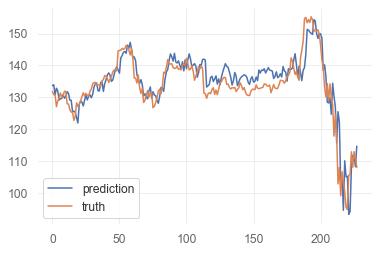

In [28]:
prediction = pd.DataFrame({"prediction": prediction})
prediction["truth"] = label_array_test
prediction.plot()

In [44]:
from sklearn.metrics import r2_score, mean_squared_error
r2_score(label_array_test,prediction['prediction']),np.sqrt(mean_squared_error(label_array_test,prediction['prediction']))

(0.794323711241896, 4.523912016294633)

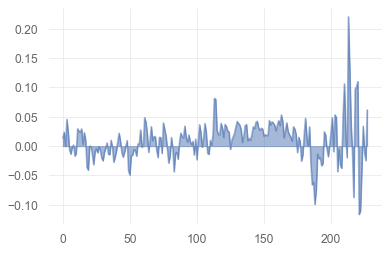

In [42]:
delta = (prediction["prediction"]/prediction["truth"])-1
delta.plot(kind="area", stacked=False)

## LSTM Neural Network
We will use Keras's `LSTM` function to build the neural networks. The networks will have two or three layers, each with hidden states dimension of 100-50 or 150-100-50. Each layer will use Relu as activation function, and each layer will have a dropout layer with keep probability of 80% in order to regularize. The output layer will have dimension of 1, and linear activation function.  

In [45]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

# build the network
nb_features = seq_array.shape[2]

model = Sequential()

model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(1))
model.compile(loss='mae', optimizer='nadam', metrics=['mean_squared_error'])

Using TensorFlow backend.


In [46]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5, 100)            98400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 100)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 128,651
Trainable params: 128,651
Non-trainable params: 0
_________________________________________________________________


In [47]:
history = model.fit(seq_array, label_array, epochs=1000, batch_size=500, validation_split=0.1, verbose=0)

We will split the data from the 2 previous years as training, and last year as validation data. We will use R-square and RMSE to check the model performance, on both benchmark model and LSTM model. Once a successful model is built, the user can choose which 20 days of data they want to use as input, and the model will predict the next date's target price.

Learning Curve

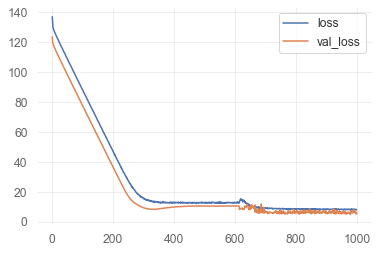

In [48]:
h = pd.DataFrame(history.history)
h[['loss', 'val_loss']].plot()

Model performance

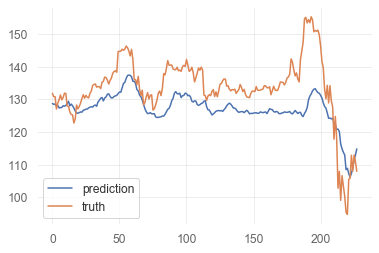

In [65]:
model.predict(seq_array_test)
prediction.columns=["prediction"]
prediction["truth"] = label_array_test
prediction.plot()

In [66]:
r2_score(label_array_test,prediction['prediction']),np.sqrt(mean_squared_error(label_array_test,prediction['prediction']))

(0.13939815667111333, 9.253865272104054)

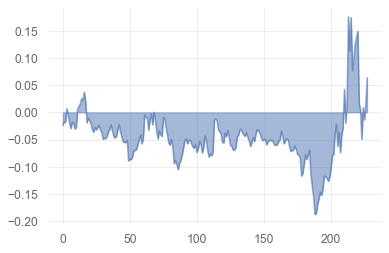

In [67]:
delta = (prediction["prediction"]/prediction["truth"])-1
delta.plot(kind="area", stacked=False)